<a href="https://colab.research.google.com/github/nekoaero/yandex_practicum/blob/main/05_main_stat_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats as st

import warnings
warnings.filterwarnings(action='ignore')

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

## Двусторонние критерии на пальцах

In [ ]:
# то до чего дошли в результате предыдущей консультации 

def get_p_value(t, n, mu0):    
    # вероятность получить t из n или больше
    # =
    # 1 - (вероятность получить t-1 из n или меньше)    
    return 1 - binom.cdf(t - 1, n, p=mu0)




In [ ]:
def get_p_value_two_sided(t, n, mu0):    
    if binom.cdf(t, n, mu0) > 0.5:        
        # right-sided 
        one_sided_p = 1 - binom.cdf(t - 1, n, p=mu0)  
        # вероятность получить t из n или больше
        # =
        # 1 - (вероятность получить t-1 из n или меньше)    
        
    else:
        # left-sided 
        one_sided_p = binom.cdf(t, n, p=mu0)  
        # вероятность получить t из n или меньше
        
    return min(one_sided_p * 2, 1)



При нахождении как левого критического значения, так и правого, используем $\frac{\alpha}{2}$ вместо $\alpha$.

### Загрузка данных

Данные скачал из https://www.kaggle.com/carrie1/ecommerce-data

This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

In [ ]:
df = pd.read_csv('data (1).csv',encoding='cp1252')

In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [ ]:
UNREGISTERED_CUSTOMER_ID = -999999.0

### Предобработка данных

In [ ]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'],format='%m/%d/%Y %H:%M')
df['CustomerID'] = df['CustomerID'].fillna(UNREGISTERED_CUSTOMER_ID)

user = df.groupby(['CustomerID'])['InvoiceDate'].min().reset_index()
user.columns = ['CustomerID','reg_date']
user['reg_month'] = user['reg_date'].values.astype('datetime64[M]')

min_month = df['InvoiceDate'].values.astype('datetime64[M]').min()
max_month = df['InvoiceDate'].values.astype('datetime64[M]').max()

dr = pd.DataFrame(pd.date_range(min_month,max_month,freq='MS'))
dr.columns = ['month']
dr['key'] = 1

user['key'] = 1
report = dr.merge(user,on='key')
report = report[report['month']>=report['reg_month']]

df['month'] = df['InvoiceDate'].values.astype('datetime64[M]')
df['revenue'] = df['Quantity'] * df['UnitPrice']

sales_month = df.groupby(['CustomerID','month'])[['revenue']].agg(['sum']).reset_index()
sales_month.columns = ['CustomerID','month','revenue']

report = report.merge(sales_month,how='left',on=['CustomerID','month'])
report['user'] = 1
report['new'] = (report['reg_month'] == report['month']) * 1
report['active'] = (report['revenue'] > 0) * 1

report['active_prev'] = (report.sort_values(by=['month'], ascending=True)
                       .groupby(['CustomerID'])['active'].shift(1))

report['change_status'] = (report['active'] != report['active_prev']) * 1

report['session_id'] = (report.sort_values(by=['month'], ascending=True)
                       .groupby(['CustomerID'])['change_status'].cumsum())

report['inactive'] = (report['active'] == 0) * 1

report['month_inactive'] = (report.sort_values(by=['month'], ascending=True)
                       .groupby(['CustomerID','session_id'])['inactive'].cumsum())

report['churn_2m'] = (report['month_inactive'] >= 2) * 1

In [ ]:
report.head()

,month,key,CustomerID,reg_date,reg_month,revenue,user,new,active,active_prev,change_status,session_id,inactive,month_inactive,churn_2m
0,2010-12-01,1,-999999.0,2010-12-01 11:52:00,2010-12-01,194353.00,1,1,1,NaN,1,1,0,0,0
1,2010-12-01,1,12347.0,2010-12-07 14:57:00,2010-12-01,711.79,1,1,1,NaN,1,1,0,0,0
2,2010-12-01,1,12348.0,2010-12-16 19:09:00,2010-12-01,892.80,1,1,1,NaN,1,1,0,0,0
3,2010-12-01,1,12370.0,2010-12-14 12:58:00,2010-12-01,1868.02,1,1,1,NaN,1,1,0,0,0
4,2010-12-01,1,12377.0,2010-12-20 09:37:00,2010-12-01,1001.52,1,1,1,NaN,1,1,0,0,0


In [ ]:
report = report[['month', 'CustomerID', 'revenue']]
report.head()

,month,CustomerID,revenue
0,2010-12-01,-999999.0,194353.00
1,2010-12-01,12347.0,711.79
2,2010-12-01,12348.0,892.80
3,2010-12-01,12370.0,1868.02
4,2010-12-01,12377.0,1001.52


Заполним нулями пропуски после даты регистрации

In [ ]:
report.fillna(0, inplace=True)
report.head()

,month,CustomerID,revenue
0,2010-12-01,-999999.0,194353.00
1,2010-12-01,12347.0,711.79
2,2010-12-01,12348.0,892.80
3,2010-12-01,12370.0,1868.02
4,2010-12-01,12377.0,1001.52


Почистим от выбросов

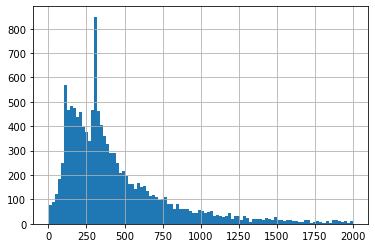

In [ ]:
report.revenue.hist(bins=100, range=(1,2000));

In [ ]:
report_filtered = report[report['revenue'] < 2000]

Смотрим сколько данных мы выкинули

In [ ]:
report.shape

(37449, 3)

In [ ]:
report_filtered.shape

(36927, 3)

# Проверка гипотез

## Параметрические тесты

### Двусторонняя проверка: Средние выручки за май и июнь одинаковы

Хотим проверить, различаются ли средние выручки у постоянных покупателей за май и за июнь.

Для удобства сделаем таблицу, где в первом столбце пользователь, а в следующих столбцах - выручка от пользователя за месяц

In [ ]:
report_filtered_pivot = report_filtered.pivot(index='CustomerID', columns='month', values='revenue')

In [ ]:
report_filtered_pivot.head()

month,2010-12-01,2011-01-01,2011-02-01,2011-03-01,2011-04-01,2011-05-01,2011-06-01,2011-07-01,2011-08-01,2011-09-01,2011-10-01,2011-11-01,2011-12-01
CustomerID,,,,,,,,,,,,,
12346.0,NaN,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.00
12347.0,711.79,475.39,0.0,0.0,636.25,0.0,382.52,0.0,584.91,0.0,1294.32,0.00,224.82
12348.0,892.80,227.44,0.0,0.0,367.00,0.0,0.00,0.0,0.00,310.0,0.00,0.00,0.00
12349.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1757.55,0.00
12350.0,NaN,NaN,334.4,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.00


Выделим постоянных покупателей - тех, кто делал покупки и в мае, и в июне

In [ ]:
regular_customers = report_filtered_pivot[(report_filtered_pivot['2011-05-01'] > 0) & (report_filtered_pivot['2011-06-01'] > 0)]

In [ ]:
regular_customers.head()

month,2010-12-01,2011-01-01,2011-02-01,2011-03-01,2011-04-01,2011-05-01,2011-06-01,2011-07-01,2011-08-01,2011-09-01,2011-10-01,2011-11-01,2011-12-01
CustomerID,,,,,,,,,,,,,
12395.0,679.92,-2.95,216.66,326.50,0.00,331.79,163.90,0.0,165.95,0.00,346.68,769.83,0.00
12399.0,NaN,NaN,NaN,288.05,0.00,480.90,130.08,0.0,209.62,0.00,0.00,0.00,0.00
12423.0,237.93,0.00,192.31,347.35,255.36,333.82,84.92,0.0,198.98,-10.20,0.00,0.00,208.64
12437.0,NaN,337.95,590.26,147.71,209.10,635.32,501.64,0.0,0.00,557.28,263.46,1488.04,165.90
12463.0,NaN,NaN,NaN,NaN,344.57,291.98,337.84,0.0,0.00,0.00,329.24,0.00,0.00


### Но сначала проверка нормальности распределения!

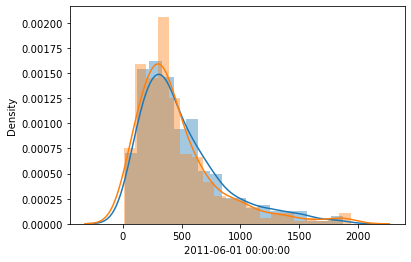

In [ ]:
sns.distplot(regular_customers['2011-05-01']);
sns.distplot(regular_customers['2011-06-01']);

#### Проверка при помощи QQ-графиков

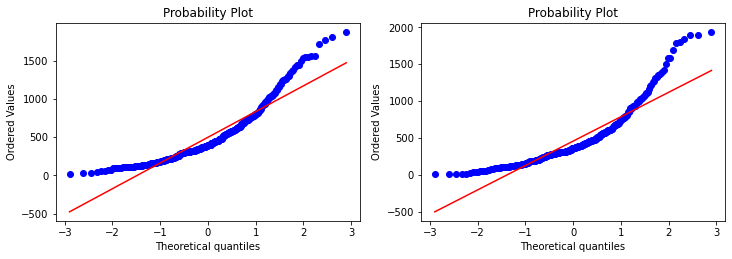

In [ ]:
# строим qq-plot для нормального распределения
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
st.probplot(regular_customers['2011-05-01'], dist="norm", plot=plt)
plt.subplot(2,2,2)
st.probplot(regular_customers['2011-06-01'], dist="norm", plot=plt)
plt.show()

#### Проверка при помощи критерий Шапиро-Уилка

In [ ]:
alpha=0.05

Критерий Шапиро-Уилка:

$\begin{equation*}
 \begin{cases}
   H_0 :\text{Средние выручки за май/июнь распределены нормально}\\
   H_1 :\text{Средние выручки за май/июнь распределены не нормально}
 \end{cases}
\end{equation*}$

In [ ]:
print("Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % st.shapiro(regular_customers['2011-05-01']))

Shapiro-Wilk normality test, W-statistic: 0.875104, p-value: 0.000000


In [ ]:
print("Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % st.shapiro(regular_customers['2011-06-01']))

Shapiro-Wilk normality test, W-statistic: 0.838997, p-value: 0.000000


In [ ]:
st.shapiro(st.norm(0,1).rvs(100000))

ShapiroResult(statistic=0.9608938097953796, pvalue=0.7960150837898254)

### Двусторонняя проверка: Средние выручки за май и июнь одинаковы

<p>Введем основную и альтернативные гипотезы:</p>

$\begin{equation*}
 \begin{cases}
   H_0 :\text{Средние выручки за май и июнь одинаковы}\\
   H_1 :\text{Средние выручки за май и июнь отличаются}
 \end{cases}
\end{equation*}$

Уровень значимости: $\alpha = 0.05$

Посчитаем p-value, используя ttest из библиотеки scipy для сравнения средних двух выборок.

Если p-value будет меньше выбранного уровня значимости $\alpha = 0.05$, то нулевую гипотезу о равенстве средних отвергнем. Иначе сделаем вывод, что данные не позволили нам отвергнуть нулевую гипотезу.

Применим ttest к выручкам за июнь и за май

In [ ]:
results = st.ttest_ind(regular_customers['2011-05-01'], regular_customers['2011-06-01'], equal_var=False)
print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.1199296294881324
Не получилось отвергнуть нулевую гипотезу


Воспользуемся тем, что выборки связаны

In [ ]:
results = st.ttest_rel(regular_customers['2011-05-01'], regular_customers['2011-06-01'])
print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.01590694684288648
Отвергаем нулевую гипотезу


Вывод: p-value получилось меньше выбранного уровня $\alpha = 0.05$. Отвергаем нулевую гипотезу - средние выручки постоянных покупателей за май и июнь отличаются

### Односторонняя проверка: Выручка в мае больше выручки в июне

$\begin{equation*}
 \begin{cases}
   H_0 :\text{Средние выручка за май и июнь одинаковы}\\
   H_1 :\text{Средняя выручка за май больше средней выручки за июнь}
 \end{cases}
\end{equation*}$

Можем использовать параметр alternative='greater'

In [ ]:
results = st.ttest_rel(regular_customers['2011-05-01'], regular_customers['2011-06-01'], alternative='greater')
print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.00795347342144324
Отвергаем нулевую гипотезу


Или проверять, как учат в программе Практикума

In [ ]:
alpha = .05 # критический уровень статистической значимости

results = st.ttest_rel(regular_customers['2011-05-01'], regular_customers['2011-06-01'])

# тест односторонний: p-value будет в два раза меньше
print('p-значение: ', results.pvalue / 2)

# тест односторонний влево:
# отвергаем гипотезу только если выборочное среднее значимо меньше предполагаемого значения
if (results.pvalue / 2 < alpha) and (regular_customers['2011-05-01'].mean() > regular_customers['2011-06-01'].mean()):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.00795347342144324
Отвергаем нулевую гипотезу


In [ ]:
regular_customers['2011-05-01'].mean()

498.3157526881718

In [ ]:
regular_customers['2011-06-01'].mean()

457.48075268817195

### Односторонняя проверка: Выручка в мае меньше выручки в июне

$\begin{equation*}
 \begin{cases}
   H_0 :\text{Средние выручка за май и июнь одинаковы}\\
   H_1 :\text{Средняя выручка за май меньше средней выручки за июнь}
 \end{cases}
\end{equation*}$

Можем использовать параметр alternative='less'

In [ ]:
results = st.ttest_rel(regular_customers['2011-05-01'], regular_customers['2011-06-01'], alternative='less')
print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.9920465265785567
Не получилось отвергнуть нулевую гипотезу


Или проверять, как учат в программе Практикума

In [ ]:
alpha = .05 # критический уровень статистической значимости

results = st.ttest_rel(regular_customers['2011-05-01'], regular_customers['2011-06-01'])

# тест односторонний: p-value будет в два раза меньше
print('p-значение: ', results.pvalue / 2)

# тест односторонний влево:
# отвергаем гипотезу только если выборочное среднее значимо меньше предполагаемого значения
if (results.pvalue / 2 < alpha) and (regular_customers['2011-05-01'].mean() < regular_customers['2011-06-01'].mean()):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.00795347342144324
Не получилось отвергнуть нулевую гипотезу


## Непараметрический тест Манна-Уитни

Используем, если распределение случайных величины очень сильно отличается от нормального

### Двусторонняя проверка

<p>Введем основную и альтернативные гипотезы:</p>

$\begin{equation*}
 \begin{cases}
   H_0 :\text{Средние выручки за май и июнь одинаковы}\\
   H_1 :\text{Средние выручки за май и июнь отличаются}
 \end{cases}
\end{equation*}$

Уровень значимости: $\alpha = 0.05$

Посчитаем p-value, используя ttest из библиотеки scipy для сравнения средних двух выборок.

Если p-value будет меньше выбранного уровня значимости $\alpha = 0.05$, то нулевую гипотезу о равенстве средних отвергнем. Иначе сделаем вывод, что данные не позволили нам отвергнуть нулевую гипотезу.

In [ ]:
results = st.mannwhitneyu(regular_customers['2011-05-01'], regular_customers['2011-06-01'], alternative='two-sided')
print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.03928658478737981
Отвергаем нулевую гипотезу


### Односторонняя проверка

$\begin{equation*}
 \begin{cases}
   H_0 :\text{Средние выручка за май и июнь одинаковы}\\
   H_1 :\text{Средняя выручка за май больше средней выручки за июнь}
 \end{cases}
\end{equation*}$

In [ ]:
results = st.mannwhitneyu(regular_customers['2011-05-01'], regular_customers['2011-06-01'], alternative='greater')
print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.019643292393689903
Отвергаем нулевую гипотезу


### Односторонняя проверка

$\begin{equation*}
 \begin{cases}
   H_0 :\text{Средние выручка за май и июнь одинаковы}\\
   H_1 :\text{Средняя выручка за май меньше средней выручки за июнь}
 \end{cases}
\end{equation*}$

In [ ]:
results = st.mannwhitneyu(regular_customers['2011-05-01'], regular_customers['2011-06-01'], alternative='less')
print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.9803729702674745
Не получилось отвергнуть нулевую гипотезу
